In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from pathlib import Path
import random
from sklearn.preprocessing import LabelEncoder



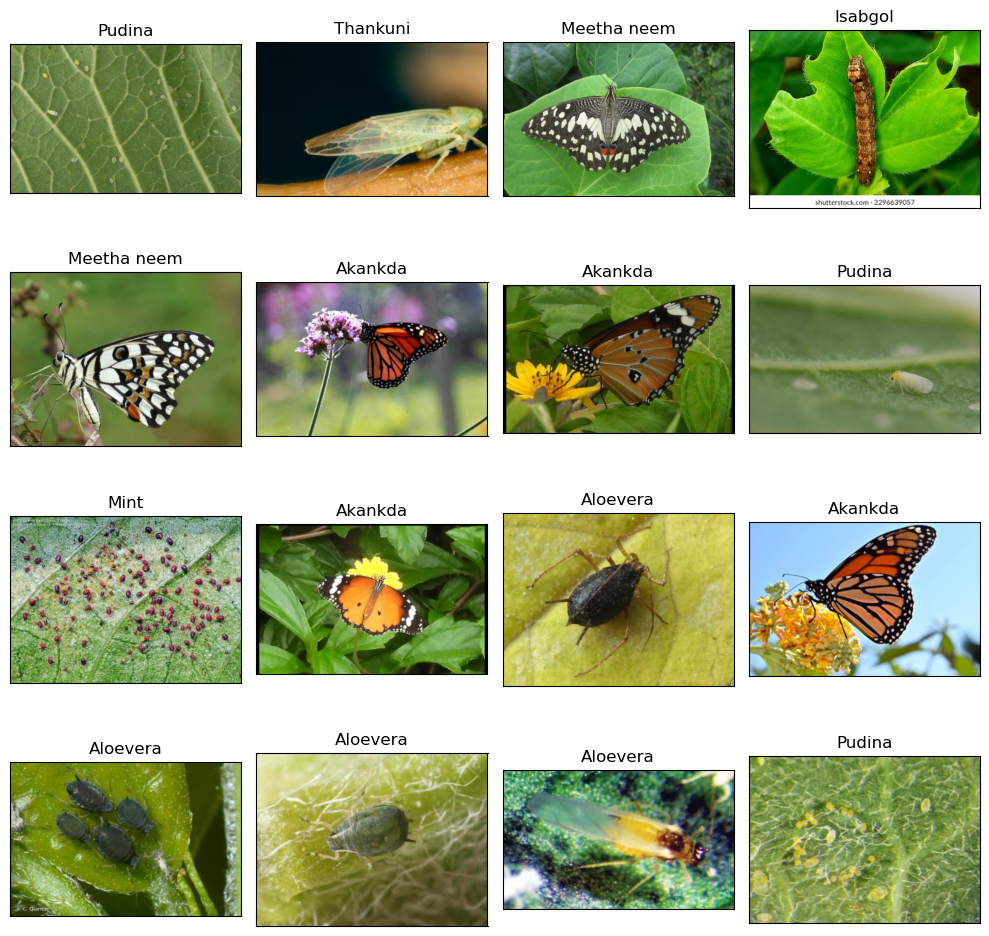

Found 1512 validated image filenames belonging to 11 classes.
Found 500 validated image filenames belonging to 11 classes.


C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 48 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [4]:

train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")
test_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\test")



def load_data(data_path):
    filepaths = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG','*.webp','*.WEBP']:
        filepaths.extend(list(data_path.rglob(ext)))  # rglob works with Path objects
    labels = [os.path.split(os.path.split(str(path))[0])[1] for path in filepaths]
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df



train_image_df = load_data(train_dir)
test_image_df = load_data(test_dir)



label_encoder = LabelEncoder()


train_image_df['Encoded_Label'] = label_encoder.fit_transform(train_image_df['Label'])


test_image_df['Encoded_Label'] = label_encoder.transform(test_image_df['Label'])


num_classes = len(label_encoder.classes_)


random_index = np.random.randint(0, len(train_image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = plt.imread(train_image_df.Filepath.iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(train_image_df.Label.iloc[random_index[i]])  
plt.tight_layout()
plt.show()


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_dataframe(
    train_image_df,
    x_col='Filepath',
    y_col='Label',  
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='Filepath',
    y_col='Label',  
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.15,        
    zoom_range=0.2,           
    horizontal_flip=True,    
    vertical_flip=True,       
    fill_mode="nearest",    
    validation_split=0.2     
)


train_generator = datagen.flow_from_dataframe(
    train_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)



test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1512 validated image filenames belonging to 11 classes.
Found 500 validated image filenames belonging to 11 classes.


C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 48 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


CLAHE

Displaying CLAHE-enhanced image from: C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train\Akankda\032478c96d184737991d2a0b1765c4cf.webp


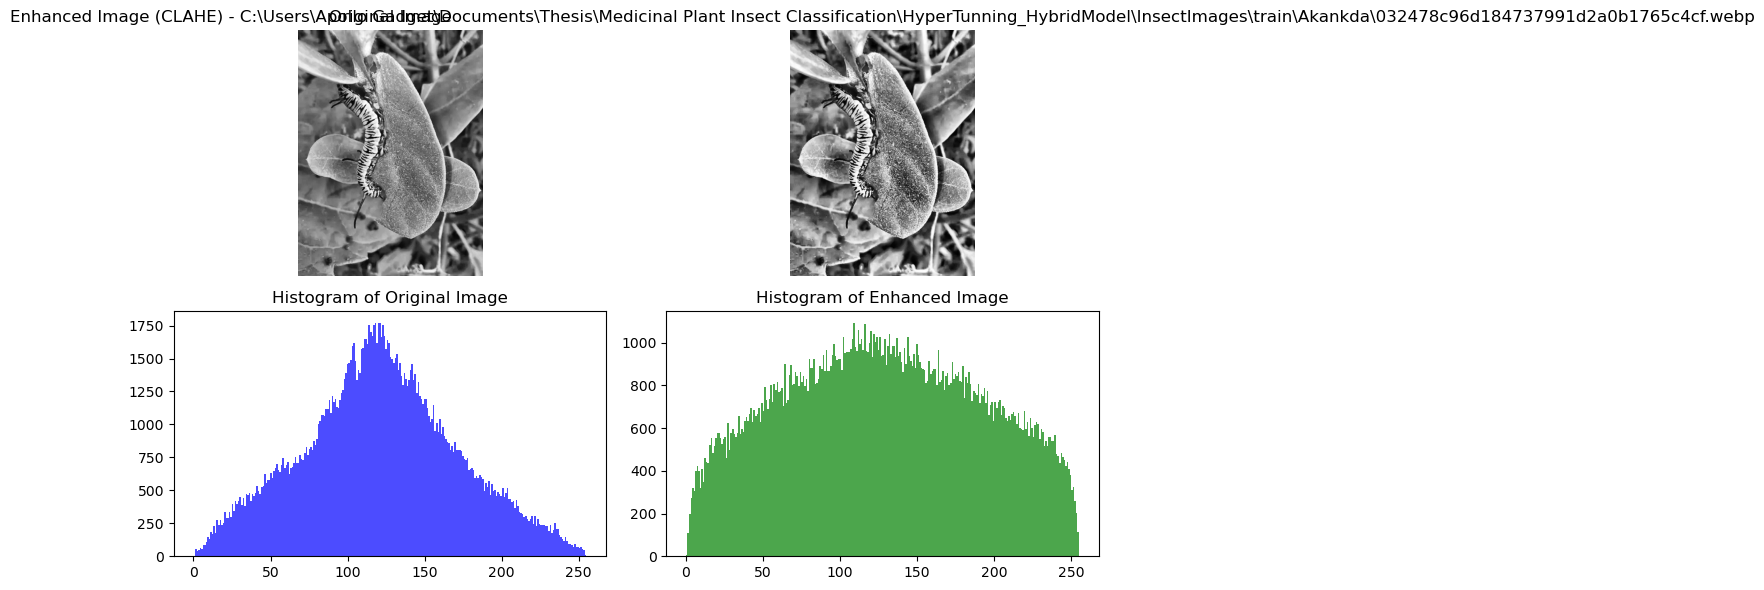

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)


def enhance_train_images(input_dir):
    all_images = []
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    clahe_image = apply_clahe(img)
                    cv2.imwrite(image_path, clahe_image)  # Overwrite the original image
                    all_images.append((img, clahe_image, image_path))  # Save paths with images for selection
                else:
                    print(f"Warning: Could not read image {image_path}")
    return all_images


def display_image_and_histogram(original, enhanced, title=""):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    
    # Original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    
    # Histogram of original image
    axes[1, 0].hist(original.ravel(), bins=256, color='blue', alpha=0.7)
    axes[1, 0].set_title("Histogram of Original Image")
    
    # Enhanced image
    axes[0, 1].imshow(enhanced, cmap='gray')
    axes[0, 1].set_title(f"Enhanced Image (CLAHE) - {title}")
    axes[0, 1].axis('off')
    
    # Histogram of enhanced image
    axes[1, 1].hist(enhanced.ravel(), bins=256, color='green', alpha=0.7)
    axes[1, 1].set_title("Histogram of Enhanced Image")
    
    plt.tight_layout()
    plt.show()


train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")


enhanced_train_images = enhance_train_images(train_dir)


if enhanced_train_images:
    original_img, enhanced_img, img_path = enhanced_train_images[1]  # Change index to select another image if desired
    print(f"Displaying CLAHE-enhanced image from: {img_path}")
    display_image_and_histogram(original_img, enhanced_img, title=img_path)
else:
    print("No images found for enhancement.")


VGG16

In [19]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")
test_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\test")


def load_data(data_path):
    filepaths = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG', '*.webp', '*.WEBP']:
        filepaths.extend(list(data_path.rglob(ext)))  # rglob works with Path objects
    labels = [os.path.split(os.path.split(str(path))[0])[1] for path in filepaths]
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df


def load_cnn_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model


def load_image(filepath, target_size=(224, 224)):
    img = load_img(filepath, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to match VGG16 input scale
    return img_array


def extract_features_from_vgg(image_df, model):
    features = []
    for filepath in image_df['Filepath']:
        img = load_image(filepath)
        feature = model.predict(img)
        features.append(feature.flatten())
    return np.array(features)


image_df = load_data(train_dir) 

X_train, X_val, y_train, y_val = train_test_split(
    image_df['Filepath'], 
    image_df['Label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=image_df['Label']
)


train_image_df = pd.DataFrame({'Filepath': X_train, 'Label': y_train})
val_image_df = pd.DataFrame({'Filepath': X_val, 'Label': y_val})


label_encoder = LabelEncoder()
train_image_df['Encoded_Label'] = label_encoder.fit_transform(train_image_df['Label'])
val_image_df['Encoded_Label'] = label_encoder.transform(val_image_df['Label'])


vgg_model = load_cnn_model()


X_train_vgg = extract_features_from_vgg(train_image_df, vgg_model)
X_val_vgg = extract_features_from_vgg(val_image_df, vgg_model)


scaler = StandardScaler()
X_train_vgg = scaler.fit_transform(X_train_vgg)
X_val_vgg = scaler.transform(X_val_vgg)


smote = SMOTE(random_state=42)
X_train_vgg_resampled, y_train_resampled = smote.fit_resample(X_train_vgg, train_image_df['Encoded_Label'].values)


print(f"Resampled training features shape: {X_train_vgg_resampled.shape}")
print(f"Resampled training labels shape: {y_train_resampled.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/

SVM with HyperTunning

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid = {
    'kernel': ['linear','rbf', 'sigmoid'],
    'max_iter': [1000,1100]
}
svm = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, scoring='accuracy')


grid_search.fit(X_train_vgg_resampled, y_train_resampled)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm = SVC(**best_params, random_state=42)
best_svm.fit(X_train_vgg_resampled, y_train_resampled)

y_pred_svm = best_svm.predict(X_val_vgg)
val_accuracy = accuracy_score(val_image_df['Encoded_Label'],y_pred_svm)
print("SVM Accuracy with Tuned Hyperparameters:", val_accuracy)


conf_matrix = confusion_matrix(val_image_df['Encoded_Label'],y_pred_svm)



print("Classification Report (Validation):")
print(classification_report(val_image_df['Encoded_Label'], y_pred_svm, target_names=label_encoder.classes_))





Best Hyperparameters: {'kernel': 'linear', 'max_iter': 1000}
SVM Accuracy with Tuned Hyperparameters: 0.9639175257731959
Classification Report (Validation):
              precision    recall  f1-score   support

     Akankda       0.95      1.00      0.98        40
    Aloevera       0.83      0.95      0.88        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       0.95      0.95      0.95        37
      Datura       0.95      1.00      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      1.00      1.00        34
        Mint       1.00      0.94      0.97        35
      Pudina       1.00      0.89      0.94        36
   Shotomuli       1.00      0.93      0.96        27
    Thankuni       1.00      0.93      0.96        29

    accuracy                           0.96       388
   macro avg       0.97      0.96      0.97       388
weighted avg       0.97      0.96      0.96       388



RF

RF with hyperparameter tunning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid_rf = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}


rf = RandomForestClassifier(random_state=42)


grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, scoring='accuracy', n_jobs=-1)


grid_search_rf.fit(X_train_vgg_resampled, y_train_resampled)


best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest Classifier:", best_params_rf)


best_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf.fit(X_train_vgg_resampled, y_train_resampled)


y_pred_rf = best_rf.predict(X_val_vgg)


accuracy_rf = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_rf)
print(f"Random Forest Classifier Accuracy with Tuned Hyperparameters: {accuracy_rf * 100:.2f}%")


confusion_rf = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_rf)
print("\nConfusion Matrix:\n", confusion_rf)


report_rf = classification_report(val_image_df['Encoded_Label'].values, y_pred_rf, 
                                  target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_rf)


Best Hyperparameters for Random Forest Classifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Classifier Accuracy with Tuned Hyperparameters: 95.88%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  2  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  2  0  0]
 [ 0  4  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  4  0  0  0  0  0  0 25]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.90      0.95      0.93        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.85      0.95      0.90        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00    

KNN

In [ ]:
KNN Hyperparameter

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}


knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=2, scoring='accuracy', n_jobs=-1)


grid_search_knn.fit(X_train_vgg_resampled, y_train_resampled)

best_params_knn = grid_search_knn.best_params_
print("Best Hyperparameters for KNN Classifier:", best_params_knn)


best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_vgg_resampled, y_train_resampled)


y_pred_knn = best_knn.predict(X_val_vgg)


accuracy_knn = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_knn)
print(f"KNN Classifier Accuracy with Tuned Hyperparameters: {accuracy_knn * 100:.2f}%")


confusion_knn = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_knn)
print("\nConfusion Matrix:\n", confusion_knn)


report_knn = classification_report(val_image_df['Encoded_Label'].values, y_pred_knn, 
                                    target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_knn)


Best Hyperparameters for KNN Classifier: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN Classifier Accuracy with Tuned Hyperparameters: 95.36%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  2]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  2  0 35  0  0  0  0  0  0  0]
 [ 0  2  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 2  0  0  0  0  0 32  0  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  0  0  4  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  2  0  0  0  0  0  0 27]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       0.95      1.00      0.98        40
    Aloevera       0.86      0.95      0.90        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       0.81      0.95      0.88        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      

NB

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}


nb = GaussianNB()


grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=2, scoring='accuracy', n_jobs=-1)


grid_search_nb.fit(X_train_vgg_resampled, y_train_resampled)

best_params_nb = grid_search_nb.best_params_
print("Best Hyperparameters for Naive Bayes Classifier:", best_params_nb)

best_nb = GaussianNB(**best_params_nb)
best_nb.fit(X_train_vgg_resampled, y_train_resampled)


y_pred_nb_tuned = best_nb.predict(X_val_vgg)


accuracy_nb_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_nb_tuned)
print(f"Accuracy of Naive Bayes with Tuned Hyperparameters: {accuracy_nb_tuned * 100:.2f}%")


confusion_nb_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_nb_tuned)
print("\nConfusion Matrix:\n", confusion_nb_tuned)

report_nb_tuned = classification_report(val_image_df['Encoded_Label'].values, y_pred_nb_tuned, 
                                        target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_nb_tuned)


Best Hyperparameters for Naive Bayes Classifier: {'var_smoothing': 1e-07}
Accuracy of Naive Bayes with Tuned Hyperparameters: 93.81%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  2  0 35  0  0  0  0  0  0  0]
 [ 2  0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  2]
 [ 0  0  2  2  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  4  0  0 23  0]
 [ 0  0  0  4  0  0  0  2  0  2 21]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       0.91      1.00      0.95        40
    Aloevera       0.95      0.95      0.95        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.85      0.95      0.90        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       0.89      1.00      0.94   

MLP

In [ ]:
MLP hyperparameter

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100)],
    'activation': ['relu', 'logistic'],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.01, 0.1]
}


mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.1)


grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=2, scoring='accuracy', n_jobs=-1)


grid_search_mlp.fit(X_train_vgg_resampled, y_train_resampled)


best_params_mlp = grid_search_mlp.best_params_
print("Best Hyperparameters for MLP Classifier:", best_params_mlp)


best_mlp = MLPClassifier(**best_params_mlp, random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.1)
best_mlp.fit(X_train_vgg_resampled, y_train_resampled)


y_pred_mlp_tuned = best_mlp.predict(X_val_vgg)


accuracy_mlp_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned)
print(f"\nMLP Classifier Accuracy with Tuned Hyperparameters: {accuracy_mlp_tuned:.4f}")


mlp_confusion_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned)
print("\nMLP Confusion Matrix with Tuned Hyperparameters:\n", mlp_confusion_tuned)


mlp_report_tuned = classification_report(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned, 
                                         target_names=label_encoder.classes_)
print("\nMLP Classification Report with Tuned Hyperparameters:\n", mlp_report_tuned)


Best Hyperparameters for MLP Classifier: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}

MLP Classifier Accuracy with Tuned Hyperparameters: 0.9149

MLP Confusion Matrix with Tuned Hyperparameters:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0  1 38  0  1  0  0  0  0  0  0]
 [ 0  1  0 34  0  0  2  0  0  0  0]
 [ 0  0  0  0 34  1  1  0  0  0  0]
 [ 0  0  0  3  0 30  0  0  1  0  0]
 [ 1  0  1  0  0  0 31  1  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  2  0  0  0  0  0  0 32  2  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  2  0  4  0  1  0  0  0  2 20]]

MLP Classification Report with Tuned Hyperparameters:
               precision    recall  f1-score   support

     Akankda       0.93      1.00      0.96        40
    Aloevera       0.83      0.95      0.88        40
 Ashwagandha       0.97      0.95      0.96        40
       Basak       0.79      0.92      0.85        37
      Datura       0.9

ExtraTree

ExtraTree hyperparameter

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid_et = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}


et = ExtraTreesClassifier(n_estimators=100, random_state=42)


grid_search_et = GridSearchCV(estimator=et, param_grid=param_grid_et, cv=2, scoring='accuracy', n_jobs=-1)


grid_search_et.fit(X_train_vgg_resampled, y_train_resampled)


best_params_et = grid_search_et.best_params_
print("Best Hyperparameters for Extra Trees Classifier:", best_params_et)


best_et = ExtraTreesClassifier(n_estimators=100, random_state=42, **best_params_et)
best_et.fit(X_train_vgg_resampled, y_train_resampled)


y_pred_et = best_et.predict(X_val_vgg)


accuracy_et = accuracy_score(val_image_df['Encoded_Label'], y_pred_et)
print("\nExtra Trees Classifier Accuracy with Tuned Hyperparameters:", accuracy_et)


extra_trees_confusion = confusion_matrix(val_image_df['Encoded_Label'], y_pred_et)
extra_trees_report = classification_report(val_image_df['Encoded_Label'], y_pred_et,
                                           target_names=label_encoder.classes_)

print("\nExtra Trees Confusion Matrix with Tuned Hyperparameters:\n", extra_trees_confusion)
print("\nExtra Trees Classification Report with Tuned Hyperparameters:\n", extra_trees_report)


Best Hyperparameters for Extra Trees Classifier: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}

Extra Trees Classifier Accuracy with Tuned Hyperparameters: 0.9690721649484536

Extra Trees Confusion Matrix with Tuned Hyperparameters:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  2  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  2  0  0]
 [ 0  2  0  2  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Extra Trees Classification Report with Tuned Hyperparameters:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.95      0.95      0.95        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.90      0.95      0.92    

Stacking Ensemble

In [35]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np


X_ensemble = np.column_stack((
    y_pred_svm,
    y_pred_rf,
    y_pred_knn,
    y_pred_nb_tuned,
    y_pred_mlp_tuned,
    y_pred_et
))


param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


base_meta_model = RandomForestClassifier(random_state=42)


tuner = GridSearchCV(estimator=base_meta_model, param_grid=param_grid_rf, 
                     scoring='accuracy', cv=3, n_jobs=-1)


tuner.fit(X_ensemble, val_image_df['Encoded_Label'].values)


best_params_rf = tuner.best_params_
print("Best Hyperparameters for Meta RandomForest Classifier:", best_params_rf)


meta_model_tuned = RandomForestClassifier(**best_params_rf, random_state=42)
meta_model_tuned.fit(X_ensemble, val_image_df['Encoded_Label'].values)


y_pred_combined_tuned = meta_model_tuned.predict(X_ensemble)


accuracy_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_combined_tuned)
print(f"Tuned Combined Classifier Accuracy: {accuracy_tuned * 100:.2f}%")


confusion_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_combined_tuned)
report_tuned = classification_report(
    val_image_df['Encoded_Label'].values, 
    y_pred_combined_tuned, 
    target_names=label_encoder.classes_
)

print("\nConfusion Matrix:\n", confusion_tuned)
print("\nClassification Report:\n", report_tuned)



Best Hyperparameters for Meta RandomForest Classifier: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Combined Classifier Accuracy: 100.00%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       1.00      1.00      1.00        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       1.00      1.00      1.00        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00    